In [1]:
# %%

import oggm
from oggm import cfg, utils, workflow, tasks, graphics, global_tasks
from oggm.core import flowline, massbalance
import salem
import xarray as xr
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import functools
from oggm.shop import gcm_climate

cfg.initialize(logging_level='WARNING')

cfg.PARAMS['use_multiprocessing']=False
cfg.PATHS['working_dir'] = '/home/gimenelu/Run_oggm_exp/'
cfg.PARAMS['continue_on_error'] = True

2023-08-21 11:45:15: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2023-08-21 11:45:15: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2023-08-21 11:45:15: oggm.cfg: Multiprocessing: using all available processors (N=16)
2023-08-21 11:45:15: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.


In [3]:
rgi_id = ['RGI60-11.03643'] #MdG 03643 #Siachen 14.07524
base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.1/elev_bands/W5E5/'
gdirs = workflow.init_glacier_directories(rgi_id, from_prepro_level=4, prepro_base_url=base_url, prepro_border=160)
gdir=gdirs[0]

cfg.PARAMS['use_inversion_params_for_run']= True

tasks.init_present_time_glacier(gdir)

2023-08-21 11:45:59: oggm.workflow: init_glacier_directories from prepro level 4 on 1 glaciers.
2023-08-21 11:45:59: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers


In [47]:
with xr.open_dataset(gdir.get_filepath('climate_historical')) as dh:
    dh = dh.load()
x = np.linspace(1,len(dh.time),len(dh.time))
#((dh.temp*(0.15*np.sin(x*np.pi/120)))+dh.temp).plot()
#((dh.prcp*(0.25*np.sin(x*np.pi/120)))+dh.prcp).plot()

test = dh
ampl_tmp = dh.temp.mean().data
ampl_prcp = dh.prcp.mean().data
#test['temp'] = (dh.temp*(0.15*np.sin(x*np.pi/120)))+dh.temp
test['temp'].values = ampl_tmp*(np.sin(x*np.pi/120))
#test['prcp'] = (dh.prcp*(2*abs(np.sin(x*np.pi/120))))
test['prcp'].values = ampl_prcp*abs(np.sin(x*np.pi/120))
#écrire dans un nv dataset puis enregistrer (nom à ajouter aux basenames) 
#ex
#test['prcp'] = (dh.prcp*(2*abs(np.sin(x*np.pi/120))))

In [50]:
path = cfg.PATHS['working_dir']+'per_glacier/'+gdir.rgi_id[:8]+'/'+gdir.rgi_id[:11]+'/'+gdir.rgi_id+'/exp_sinus.nc'

test.to_netcdf(path)

In [51]:
cfg.add_to_basenames('exp_sinus','exp_sinus.nc')

In [134]:
import time
import timeit

In [145]:
cfg.PARAMS["evolution_model"] = "SemiImplicit"  

2023-08-21 12:21:33: oggm.cfg: PARAMS['evolution_model'] changed from `FluxBased` to `SemiImplicit`.


In [146]:
tic = time.perf_counter()
workflow.execute_entity_task(tasks.run_from_climate_data,gdir,ys=1901,
                                         climate_filename='exp_sinus',
                                         output_filesuffix='_semi')
toc = time.perf_counter()
semi_t = toc-tic

2023-08-21 12:21:35: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-08-21 12:21:35: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.


In [147]:
ds = utils.compile_run_output(gdir, input_filesuffix='_semi')

2023-08-21 12:21:36: oggm.utils: Applying global task compile_run_output on 1 glaciers
2023-08-21 12:21:36: oggm.utils: Applying compile_run_output on 1 gdirs.


In [148]:
cfg.PARAMS["evolution_model"] = "SIA1D"  

2023-08-21 12:21:38: oggm.cfg: PARAMS['evolution_model'] changed from `SemiImplicit` to `SIA1D`.


In [149]:
tic = time.perf_counter()
workflow.execute_entity_task(tasks.run_from_climate_data,gdir,ys=1901,
                                         climate_filename='exp_sinus',
                                         output_filesuffix='_julia')
toc = time.perf_counter()
sia1D_t = toc-tic

2023-08-21 12:21:40: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-08-21 12:21:40: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.


In [150]:
ds2 = utils.compile_run_output(gdir, input_filesuffix='_julia')

2023-08-21 12:21:42: oggm.utils: Applying global task compile_run_output on 1 glaciers
2023-08-21 12:21:42: oggm.utils: Applying compile_run_output on 1 gdirs.


In [151]:
cfg.PARAMS["evolution_model"] = "FluxBased"  

2023-08-21 12:21:43: oggm.cfg: PARAMS['evolution_model'] changed from `SIA1D` to `FluxBased`.


In [152]:
tic = time.perf_counter()
workflow.execute_entity_task(tasks.run_from_climate_data,gdir,ys=1901,
                                         climate_filename='exp_sinus',
                                         output_filesuffix='_flux')
toc = time.perf_counter()
flux_t = toc-tic

2023-08-21 12:21:44: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-08-21 12:21:44: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.


In [153]:
ds3 = utils.compile_run_output(gdir, input_filesuffix='_flux')

2023-08-21 12:21:49: oggm.utils: Applying global task compile_run_output on 1 glaciers
2023-08-21 12:21:49: oggm.utils: Applying compile_run_output on 1 gdirs.


In [85]:
test=test.to_dataframe()
test2 = test.resample('A',convention='start').mean()
xr_hist=test2.to_xarray()
tt = xr_hist.time.values.astype("M8[Y]").astype('float64')+1970
xr_hist['time']=tt

(1901.0, 2020.0)

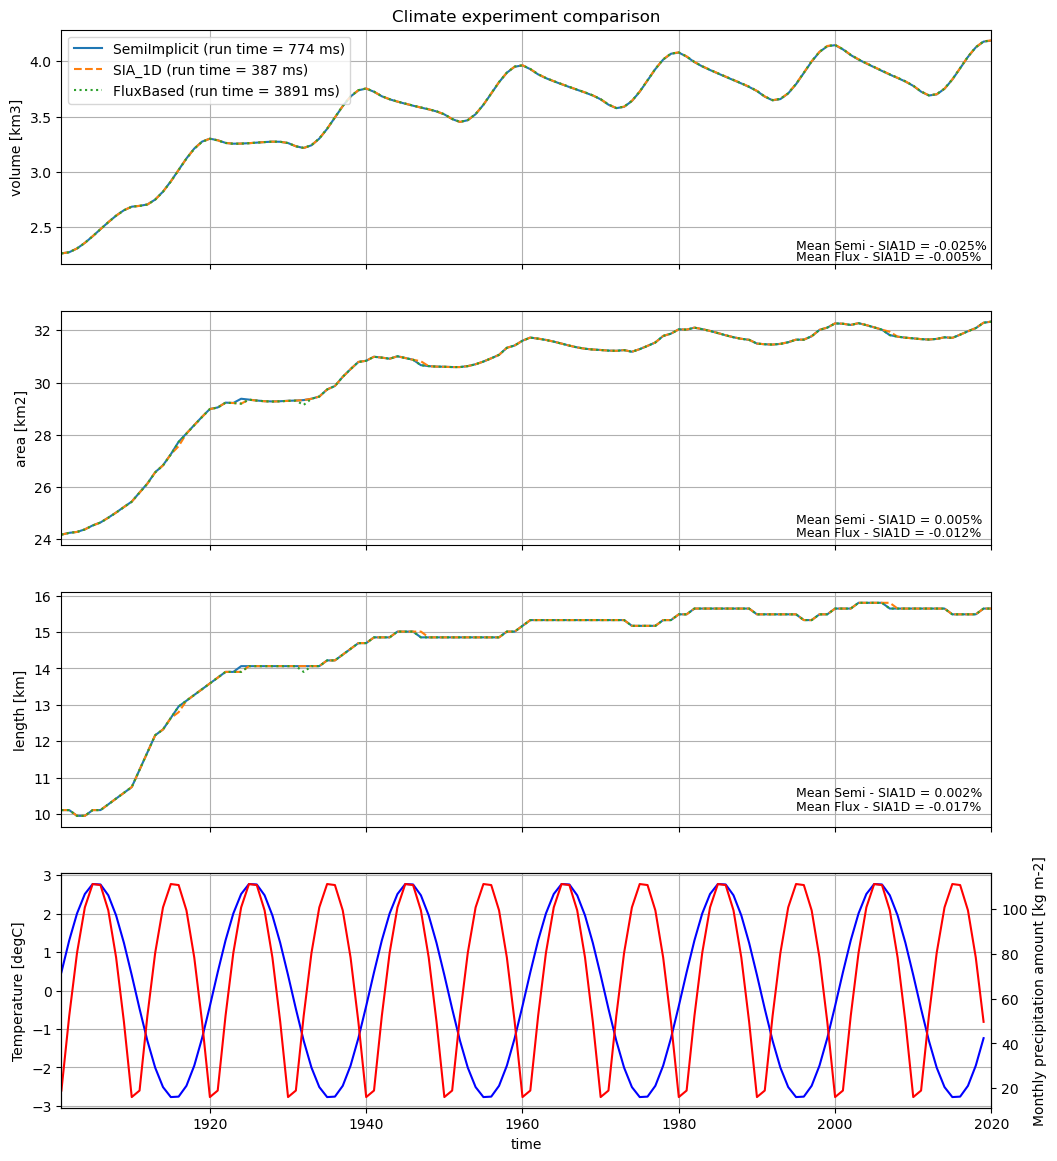

In [160]:
f, (ax1, ax2,ax3,ax4) = plt.subplots(4, 1, figsize=(12, 14),sharex=True)

(ds.volume*1e-9).plot(ax=ax1,label="SemiImplicit (run time = {} ms)".format(round(semi_t*1e3)))
(ds2.volume*1e-9).plot(ax=ax1,linestyle="dashed",label="SIA_1D (run time = {} ms)".format(round(sia1D_t*1e3)))
(ds3.volume*1e-9).plot(ax=ax1,linestyle=":",label="FluxBased (run time = {} ms)".format(round(flux_t*1e3)))
err_s = round(((ds.volume-ds2.volume)/ds.volume).mean().data*100,3)
err_f = round(((ds3.volume-ds2.volume)/ds3.volume).mean().data*100,3)
ax1.text(1995, 2.3, 'Mean Semi - SIA1D = {}%'.format(err_s), fontsize = 9)
ax1.text(1995, 2.2, 'Mean Flux - SIA1D = {}%'.format(err_f), fontsize = 9)

(ds.area*1e-6).plot(ax=ax2)
(ds2.area*1e-6).plot(ax=ax2,linestyle='dashed')
(ds3.area*1e-6).plot(ax=ax2,linestyle=':')
err_s = round(((ds.area-ds2.area)/ds.area).mean().data*100,3)
err_f = round(((ds3.area-ds2.area)/ds3.area).mean().data*100,3)
ax2.text(1995, 24.6, 'Mean Semi - SIA1D = {}%'.format(err_s), fontsize = 9)
ax2.text(1995, 24.1, 'Mean Flux - SIA1D = {}%'.format(err_f), fontsize = 9)

(ds.length*1e-3).plot(ax=ax3)
(ds2.length*1e-3).plot(ax=ax3,linestyle="dashed")
(ds3.length*1e-3).plot(ax=ax3,linestyle=':')
err_s = round(((ds.length-ds2.length)/ds.length).mean().data*100,3)
err_f = round(((ds3.length-ds2.length)/ds3.length).mean().data*100,3)
ax3.text(1995, 10.5, 'Mean Semi - SIA1D = {}%'.format(err_s), fontsize = 9)
ax3.text(1995, 10.1, 'Mean Flux - SIA1D = {}%'.format(err_f), fontsize = 9)

ax1.grid()
ax1.set_ylabel('volume [km3]')
ax1.set_xlabel('')
ax2.grid()
ax2.set_ylabel('area [km2]')
ax2.set_xlabel('')
ax2.set_title('')
ax3.grid()
ax3.set_ylabel('length [km]')
ax3.set_title('')
ax1.legend(loc=2)
ax3.set_xlabel('')
#ax1.set_xlim([2020,2100])
ax1.set_title('Climate experiment comparison')
ax4.set_xlabel('time')
ax4.grid()
ax4.plot(xr_hist.time,xr_hist.temp,color='b')
ax4.set_ylabel('Temperature [degC]')
               
ax4b=ax4.twinx()
ax4b.plot(xr_hist.time,xr_hist.prcp, color='r')
ax4b.set_ylabel('Monthly precipitation amount [kg m-2]')
ax4.set_xlim([1901,2020])